<b><h1>Books Recommendation System

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<b><h3>Dataset

In [49]:
dataset_path = r'C:\Users\FOMO\Desktop\Proj\Dataset\Book-Crossing_2\ratings.csv'
output_dir = r'C:\Users\FOMO\Desktop\Proj\Dataset\Book-Crossing_2\processed_data'  # desired output directory
ratings_df = pd.read_csv(dataset_path)
ratings_df.head()

,user_id,book_id,rating
0,2,0195153448,0
1,8,0002005018,5
2,11400,0002005018,0
3,11676,0002005018,8
4,41385,0002005018,0


In [25]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

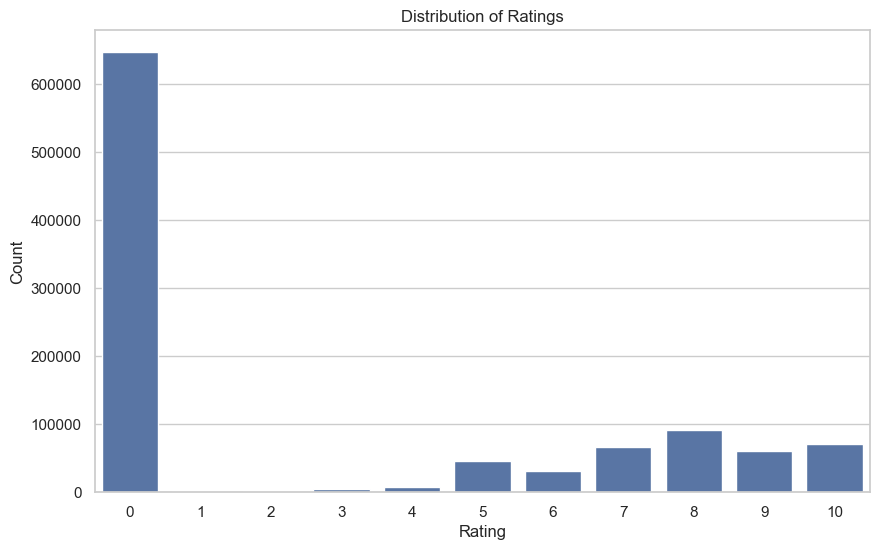

In [26]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

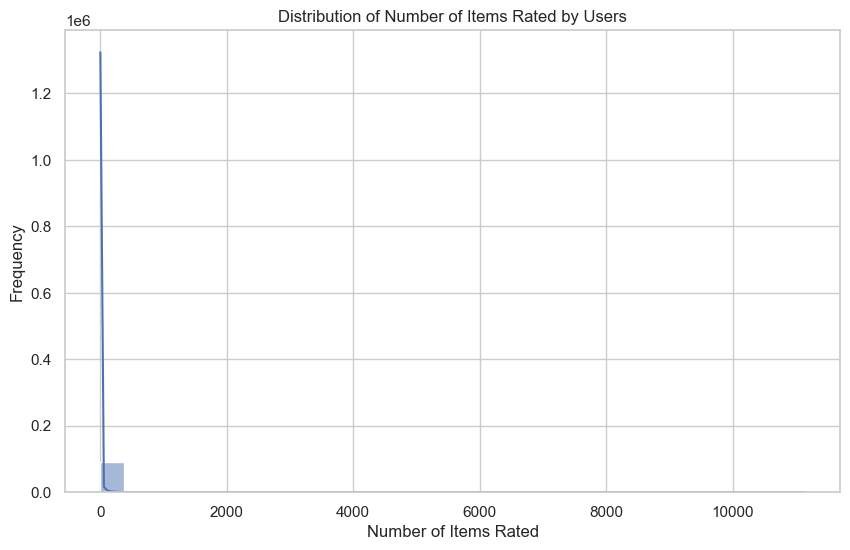

In [27]:
# Distribution of Number of Items Rated by Each User
user_rating_count = ratings_df.groupby('user_id').size()
user_rating_stats = user_rating_count.describe()

plt.figure(figsize=(10, 6))
sns.histplot(user_rating_count, bins=30, kde=True)
plt.title('Distribution of Number of Items Rated by Users')
plt.xlabel('Number of Items Rated')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

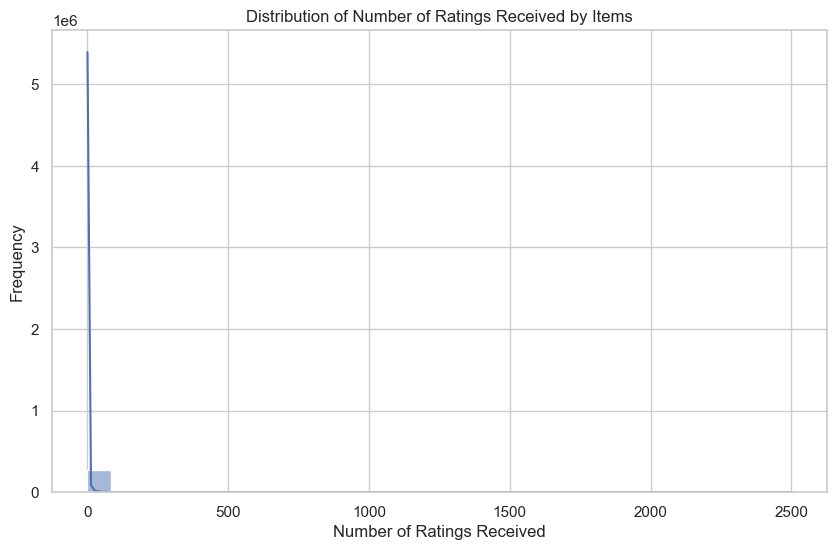

In [28]:
# Distribution of Number of Ratings Received by Each Item
item_rating_count = ratings_df.groupby('book_id').size()
item_rating_stats = item_rating_count.describe()

plt.figure(figsize=(10, 6))
sns.histplot(item_rating_count, bins=30, kde=True)
plt.title('Distribution of Number of Ratings Received by Items')
plt.xlabel('Number of Ratings Received')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [41]:
threshold = 6  # rating threshold
min_items_per_user = 3  # minimum items per user
min_users_per_item = 2  # minimum users per item
n_heldout_users = 2000  # number of heldout users

In [30]:
raw_data = ratings_df[ratings_df['rating'] > threshold]

In [34]:
def get_count(tp, id):
    playcount_groupbyid = tp.groupby(id)
    count = playcount_groupbyid.size()
    return count

In [35]:
def filter_triplets(tp, min_uc=min_items_per_user, min_sc=min_users_per_item): 
    if min_sc > 0:
        itemcount = get_count(tp, 'book_id')
        tp = tp[tp['book_id'].isin(itemcount.index[itemcount >= min_sc])]
    
    if min_uc > 0:
        usercount = get_count(tp, 'user_id')
        tp = tp[tp['user_id'].isin(usercount.index[usercount >= min_uc])]
    
    usercount, itemcount = get_count(tp, 'user_id'), get_count(tp, 'book_id') 
    return tp, usercount, itemcount

In [36]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [37]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 167198 watching events from 12988 users and 37286 movies (sparsity: 0.035%)


In [39]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [42]:
# create train/validation/test users
n_users = unique_uid.size

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [43]:
len(tr_users), len(vd_users), len(te_users)

(8988, 2000, 2000)

In [44]:
train_plays = raw_data.loc[raw_data['user_id'].isin(tr_users)]

In [45]:
unique_sid = pd.unique(train_plays['book_id'])

In [46]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [47]:
import os

In [50]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(os.path.join(output_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)
        
with open(os.path.join(output_dir, 'unique_uid.txt'), 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)

In [51]:
import sys

In [56]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user_id')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list) if tr_list else pd.DataFrame()
    data_te = pd.concat(te_list) if te_list else pd.DataFrame()
    
    return data_tr, data_te

In [54]:
vad_plays = raw_data.loc[raw_data['user_id'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['book_id'].isin(unique_sid)]

In [57]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled


In [59]:
test_plays = raw_data.loc[raw_data['user_id'].isin(te_users)]
test_plays = test_plays.loc[test_plays['book_id'].isin(unique_sid)]

In [60]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled


In [61]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['user_id']))
    sid = list(map(lambda x: show2id[x], tp['book_id']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [62]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(output_dir, 'train.csv'), index=False)

In [63]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(output_dir, 'validation_tr.csv'), index=False)

In [64]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(output_dir, 'validation_te.csv'), index=False)

In [65]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(output_dir, 'test_tr.csv'), index=False)

In [66]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(output_dir, 'test_te.csv'), index=False)

In [67]:
import numpy as np
import torch
from torch import optim
import random
from copy import deepcopy
from utils import get_data, ndcg, recall
from model import VAE

In [68]:
hidden_dim = 600
latent_dim = 200
batch_size = 500
beta = None
gamma = 0.005
n_epochs = 50  # 训练周期数
not_alternating = False  # 是否使用交替训练
n_enc_epochs = 3  # 编码器训练周期数
n_dec_epochs = 1  # 解码器训练周期数

In [69]:
dataset = r'C:\Users\FOMO\Desktop\Proj\Dataset\Book-Crossing_2\processed_data'

In [70]:
data = get_data(dataset)
train_data, valid_in_data, valid_out_data, test_in_data, test_out_data = data

In [71]:
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [72]:
device = torch.device("cuda:0")

In [73]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        
        ratings_in = batch.get_ratings_to_dev()
        ratings_out = batch.get_ratings(is_out=True)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()

            for optimizer in opts:
                optimizer.zero_grad()
                
            _, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [74]:
model_kwargs = {
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'input_dim': train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 100}]

In [75]:
best_ndcg = -np.inf
train_scores, valid_scores = [], []

In [76]:
model = VAE(**model_kwargs).to(device)
model_best = VAE(**model_kwargs).to(device)

In [77]:
learning_kwargs = {
    'model': model,
    'train_data': train_data,
    'batch_size': batch_size,
    'beta': beta,
    'gamma': gamma
}

In [78]:
decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

In [79]:
optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

In [80]:
for epoch in range(n_epochs):

    if not_alternating:
        run(opts=[optimizer_encoder, optimizer_decoder], n_epochs=1, dropout_rate=0.5, **learning_kwargs)
    else:
        run(opts=[optimizer_encoder], n_epochs=n_enc_epochs, dropout_rate=0.5, **learning_kwargs)
        model.update_prior()
        run(opts=[optimizer_decoder], n_epochs=n_dec_epochs, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, train_data, train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')

c:\Users\FOMO\Desktop\Proj\BookRS\utils.py:98: RuntimeWarning: invalid value encountered in divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.5896
epoch 1 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.7637
epoch 2 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.8132
epoch 3 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.8595
epoch 4 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9216
epoch 5 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9589
epoch 6 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9780
epoch 7 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9879
epoch 8 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9926
epoch 9 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9954
epoch 10 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9970
epoch 11 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9985
epoch 12 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.9990
epoch 13 | valid ndcg@100: nan | be

In [81]:
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

In [82]:
final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

c:\Users\FOMO\Desktop\Proj\BookRS\utils.py:111: RuntimeWarning: invalid value encountered in divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


In [83]:
for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

ndcg@100:	nan
recall@20:	nan
recall@50:	nan
